# YOLO Object Detection in Images

In [1]:
import numpy as np
import time
import cv2

In [2]:
# Load COCO class labels
labelsPath = './yolo-coco/coco.names'
labels = open(labelsPath).read().strip().split('\n')
print("Number of labels:", len(labels))

Number of labels: 25


In [3]:
# Associate each label with a certain color
np.random.seed(42)
colors = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

In [4]:
# Constants to use with YOLO
min_confidence = 0.5
min_threshold = 0.3

In [5]:
configPath = './yolo-coco/yolov3.cfg'
weightsPath = './yolo-coco/yolov3.weights'

# Load YOLO Object detector trained on COCO dataset
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

## Test DNN on Image

In [52]:
# Load an image
image = cv2.imread('./data_object_image_2/testing/image_2/000061.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
(height, width) = image.shape[:2]

In [53]:
# Get output layer names from YOLO Model
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [54]:
# Construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
net.setInput(blob)

In [55]:
%%time
layerOutputs = net.forward(ln)

CPU times: user 1.86 s, sys: 26.9 ms, total: 1.88 s
Wall time: 315 ms


In [56]:
boxes = [] # Bounding boxes
confidences = [] # Confidence values assigned to an object
classIDs = [] # objects' class label

In [118]:
def get_boxes_and_confidences(layerOutputs, boxes, confidences, classIDs, width, height):
    for output in layerOutputs:
        for detection in output:
            # Get classID and confidence from object detection
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # Filter out weak predictions
            if confidence > min_confidence:
                box = detection[0:4] * np.array([width, height, width, height])
                (centerX, centerY, box_width, box_height) = box.astype('int')

                # Get top left corner of the box
                x = int(centerX - (box_width/2))
                y = int(centerY - (box_height/2))

                # Update boxes, confidences, and classIDs
                boxes.append([x, y, int(box_width), int(box_height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

In [119]:
get_boxes_and_confidences(layerOutputs, boxes, confidences, classIDs, width, height)
print(classIDs) # Car detected

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [59]:
idxs = cv2.dnn.NMSBoxes(boxes, confidences, min_confidence, min_threshold)

In [90]:
def draw_boxes(idxs, image, boxes, classIDs, confidences):
    if len(idxs) > 0: # If object was detected only
        for i in idxs.flatten():
            # Get bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            # Draw bounding box
            color = [int(c) for c in colors[classIDs[i]]]
            cv2.rectangle(image, (x, y), (x+w, y+h), color, 2)
            text = "{}: {:.4f}".format(labels[classIDs[i]], confidences[i])
            cv2.putText(image, text, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

In [79]:
print(boxes)

[[200, 181, 255, 66], [960, 69, 273, 304], [84, 186, 289, 118], [953, 121, 292, 247], [-3, 183, 266, 202], [956, 151, 289, 226], [-6, 193, 268, 192], [357, 168, 124, 49], [355, 168, 131, 47], [393, 169, 93, 45], [367, 168, 130, 46], [616, 171, 88, 46], [630, 172, 83, 47], [246, 174, 201, 80], [701, 182, 166, 61], [707, 177, 160, 76], [249, 180, 196, 73], [731, 188, 122, 67], [705, 191, 162, 62], [714, 184, 152, 75], [97, 184, 265, 136], [137, 189, 229, 125], [0, 199, 247, 169], [0, 200, 243, 181], [611, 173, 42, 35], [200, 181, 255, 66], [960, 69, 273, 304], [84, 186, 289, 118], [953, 121, 292, 247], [-3, 183, 266, 202], [956, 151, 289, 226], [-6, 193, 268, 192], [357, 168, 124, 49], [355, 168, 131, 47], [393, 169, 93, 45], [367, 168, 130, 46], [616, 171, 88, 46], [630, 172, 83, 47], [246, 174, 201, 80], [701, 182, 166, 61], [707, 177, 160, 76], [249, 180, 196, 73], [731, 188, 122, 67], [705, 191, 162, 62], [714, 184, 152, 75], [97, 184, 265, 136], [137, 189, 229, 125], [0, 199, 247, 1

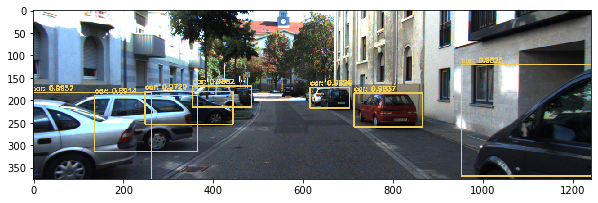

In [80]:
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
draw_boxes(idxs, image, boxes, classIDs, confidences)
plt.imshow(image)
plt.show()

## Concat into Method

In [120]:
def object_detect(image_path):
    # Get image and details
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    (height, width) = image.shape[:2]
    
    # Get output layer names from YOLO Model
    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    
    # Construct a blob from the image
    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    
    # Forward pass through YOLO Network
    layerOutputs = net.forward(ln)
    
    boxes = [] # Bounding boxes
    confidences = [] # Confidence values assigned to an object
    classIDs = [] # objects' class label
    get_boxes_and_confidences(layerOutputs, boxes, confidences, classIDs, width, height)
    #print(classIDs)
    #print(boxes)
    
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, min_confidence, min_threshold)
    
    draw_boxes(idxs, image, boxes, classIDs, confidences)
    plt.imshow(image)
    plt.show()

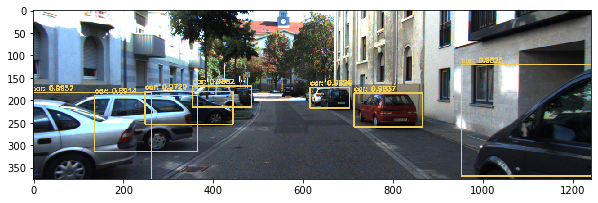

In [121]:
image_path_2 = './data_object_image_2/testing/image_2/000061.png'
object_detect(image_path_2)

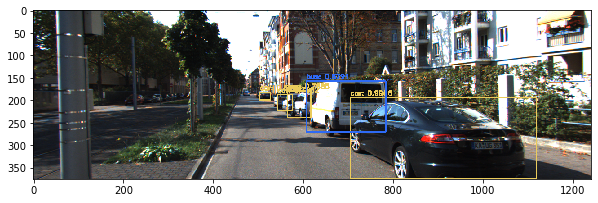

In [122]:
image_path_3 = './data_object_image_2/testing/image_2/001061.png'
object_detect(image_path_3)

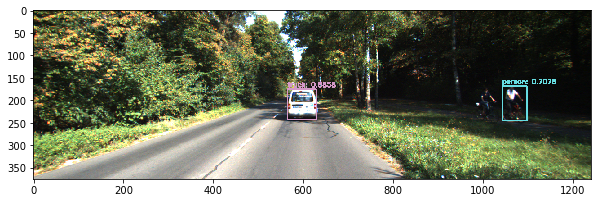

In [123]:
image_path_4 = './data_object_image_2/testing/image_2/007512.png'
object_detect(image_path_4)

## YOLO Object Detection on Video

In [115]:
import imutils

In [127]:
vs = cv2.VideoCapture('./overpass.mp4')
writer = None
(W, H) = (None, None)

try:
    prop = cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() else cv2.CAP_PROP_FRAME_COUNT
    total = int(vs.get(prop))
    print("{} total frames in video".format(total))
except:
    print("Could not determine # of frames in video")
    print("No approx. completion time can be provided")
    total = -1 

812 total frames in video


In [128]:
# Process frames one by one
while True:
    # Read the next frame
    (grabbed, frame) = vs.read()
    if not grabbed:
        break
    if W is None or H is None:
        (H, W) = frame.shape[:2]
        
    blob_video = cv2.dnn.blobFromImage(frame, 1/255.0, (416, 416), swapRB=True, crop=False)
    start = time.time()
    net.setInput(blob_video)
    end = time.time()
    layerOutputs_video = net.forward(ln)

    boxes_video = []
    confidences_video = []
    classIDs_video = []
    
    get_boxes_and_confidences(layerOutputs_video, boxes_video, confidences_video, classIDs_video, W, H)
    
    idxs_video = cv2.dnn.NMSBoxes(boxes_video, confidences_video, min_confidence, min_threshold)
    
    draw_boxes(idxs_video, frame, boxes_video, classIDs_video, confidences_video)
    
    if writer is None:
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter("./overpass-box.avi", fourcc, 30, (frame.shape[1], frame.shape[0]), True)
        #if total > 0:
        #    elapsedTime = end - start
        #    print("Single frame took {:.4f} seconds".format(elapsedTime))
    writer.write(frame)
        
print("Finished saving video")
writer.release()
vs.release()

Finished saving video
